<a href="https://colab.research.google.com/github/ericlewisX/trafficsignclassifier/blob/main/Traffic_Signs_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.5.0
Running on TPU  ['10.64.247.74:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.64.247.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.64.247.74:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
!curl https://sdk.cloud.google.com | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   443  100   443    0     0  17720      0 --:--:-- --:--:-- --:--:-- 18458
######################################################################## 100.0%
Running install script from: /tmp/tmp.hPyXnJ4b5E/install_google_cloud_sdk.bash
which curl
curl -# -f https://dl.google.com/dl/cloudsdk/channels/rapid/google-cloud-sdk.tar.gz
######################################################################## 100.0%

mkdir -p /root
"/root/google-cloud-sdk" already exists and may contain out of date files.
Remove /root/google-cloud-sdk or select a new installation directory, then run again.


In [4]:
!gcloud init

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
compute:
  gce_metadata_read_timeout_sec: '0'
core:
  account: eric.lewish@gmail.com
  project: colorfy-322000

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  1

Your current configuration has been set to: [default]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

Choose the account you would like to use to perform operations for 
this configuration:
 [1] eric.lewish@gmail.com
 [2] Log in with a new account
Please enter your numeric choice:  1

You are logged in as: [eric.lewish@gmail.com].

Pick cloud pro

In [5]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list

In [6]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   145k      0 --:--:-- --:--:-- --:--:--  145k
OK


In [7]:
!apt -qq update

98 packages can be upgraded. Run 'apt list --upgradable' to see them.


In [8]:
!apt -qq install gcsfuse

gcsfuse is already the newest version (0.36.0).
0 upgraded, 0 newly installed, 0 to remove and 98 not upgraded.


In [9]:
!mkdir imagedataset

mkdir: cannot create directory ‘imagedataset’: File exists


In [10]:
!gcsfuse --implicit-dirs trafficsignclassifier imagedataset/

2021/08/08 18:14:28.576184 Using mount point: /content/imagedataset
2021/08/08 18:14:28.583500 Opening GCS connection...
2021/08/08 18:14:28.746310 Mounting file system "trafficsignclassifier"...
2021/08/08 18:14:28.747214 File system has been successfully mounted.


In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [42]:
early_stopping = EarlyStopping(monitor='loss', 
                               patience=5, mode='auto'
                               )
# model_checkpoint = ModelCheckpoint(filepath='./drive/MyDrive/Capstone3/TrafficSigns/modelX.h5', 
#                                    monitor='val_accuracy', save_best_only=True)
tensor_board = TensorBoard(log_dir="./logs" )

In [50]:
import os
import cv2
import pickle
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer, Dense, \
                                    Conv2DTranspose, MaxPooling2D, Dropout, Flatten, Input
# from keras.layers import Dense
# from keras.layers import Dropout, Flatten                                
# from keras.layers.convolutional import Conv2D, MaxPooling2D

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from PIL import Image
from skimage.io import imsave, imshow

from tensorflow.keras import datasets, models



In [14]:
################# Parameters #####################
 
path = "imagedataset/TrafficSignClassifier/data/myData/images/" # folder with all the class folders
labelFile = 'imagedataset/TrafficSignClassifier/labels.csv' # file with all names of classes
batch_size_val = 50  # how many to process together
steps_per_epoch_val = 2000
epochs_val = 3
imageDimesions = (32,32,3)
testRatio = 0.2    # if 1000 images split will 200 for testing
validationRatio = 0.2 # if 1000 images 20% of remaining 800 will be 160 for validation
###################################################

In [15]:
# ############################### Importing of the Images
# count = 0
# images = []
# classNo = []
myList = os.listdir(path)
# print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)
# print("Importing Classes.....")
# for x in range (0,len(myList)):
#     myPicList = os.listdir(path+"/"+str(count))
#     for y in myPicList:
#         curImg = cv2.imread(path+"/"+str(count)+"/"+y)
#         images.append(curImg)
#         classNo.append(count)
#     print(count, end =" ")
#     count +=1
# print(" ")
# images = np.array(images)
# classNo = np.array(classNo)

In [17]:
# with open('images_array.pickle', 'wb') as f:
#   pickle.dump(images, f)

# with open('classNo.pickle', 'wb') as f:
#   pickle.dump(classNo, f)

In [16]:
with open('images_array.pickle', 'rb') as fi:
  images2 = pickle.load(fi)

with open('classNo.pickle', 'rb') as fi:
  classNo2 = pickle.load(fi)

In [17]:

############################### Split Data
X_train, X_test, y_train, y_test = train_test_split(images2, classNo2, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)
 
# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID

In [18]:
############################### TO CHECK IF NUMBER OF IMAGES MATCHES TO NUMBER OF LABELS FOR EACH DATA SET
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");
print(X_validation.shape,y_validation.shape)
print("Test",end = "");
print(X_test.shape,y_test.shape)
assert(X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(X_validation.shape[0]==y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert(X_train.shape[1:]==(imageDimesions))," The dimesions of the Training images are wrong "
assert(X_validation.shape[1:]==(imageDimesions))," The dimesions of the Validation images are wrong "
assert(X_test.shape[1:]==(imageDimesions))," The dimesions of the Test images are wrong"

Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


In [19]:
X_train[0].shape

(32, 32, 3)

In [20]:
############################### READ CSV FILE
data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


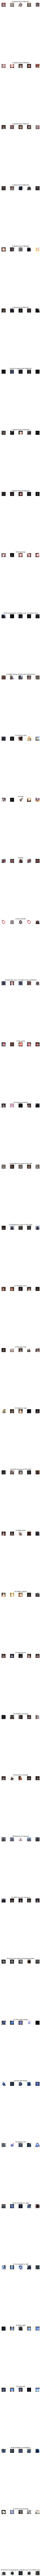

In [21]:
############################### DISPLAY SOME SAMPLES IMAGES  OF ALL THE CLASSES
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)- 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-"+row["Name"])
            num_of_samples.append(len(x_selected))

[114, 1244, 1333, 820, 1083, 1078, 227, 802, 822, 847, 1124, 717, 1178, 1213, 435, 337, 219, 637, 700, 119, 181, 172, 229, 286, 160, 865, 355, 133, 320, 160, 252, 461, 147, 387, 238, 695, 218, 115, 1210, 172, 187, 134, 145]


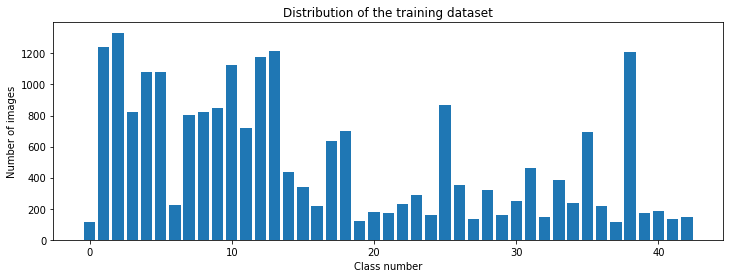

In [22]:
############################### DISPLAY A BAR CHART SHOWING NO OF SAMPLES FOR EACH CATEGORY
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()
 

In [23]:
X_train[0].shape

(32, 32, 3)

In [25]:
############################### PREPROCESSING THE IMAGES
def grayscale(img):
    img = img.astype(np.float32)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_expanded = gray[:, :, np.newaxis]
    return img_expanded

def equalize(img):
    img1 = np.uint8(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX))
    img = cv2.equalizeHist(img1)
    return img

In [26]:
def preprocessing(img):

  img = grayscale(img)     # CONVERT TO GRAYSCALE
  
  img = equalize(img)      # STANDARDIZE THE LIGHTING IN AN IMAGE
  img = img/255            # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
  return img

X_train=np.array(list(map(preprocessing,X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES


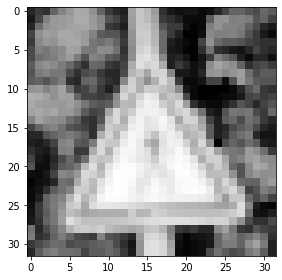

In [27]:
imshow(X_train[52])

In [28]:
X_validation=np.array(list(map(preprocessing, X_validation)))
X_test=np.array(list(map(preprocessing, X_test)))

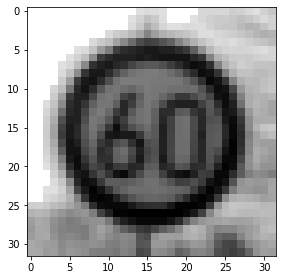

In [29]:
imshow(X_train[random.randint(0,len(X_train)-1)]) # TO CHECK IF THE TRAINING IS DONE PROPERLY
 

In [30]:
############################### ADD A DEPTH OF 1
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
 

In [31]:
############################### AUGMENTATAION OF IMAGES: TO MAKEIT MORE GENERIC
dataGen= ImageDataGenerator(width_shift_range=0.1,   # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                            height_shift_range=0.1,
                            zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                            shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                            rotation_range=10)  # DEGREES
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch,y_batch = next(batches)


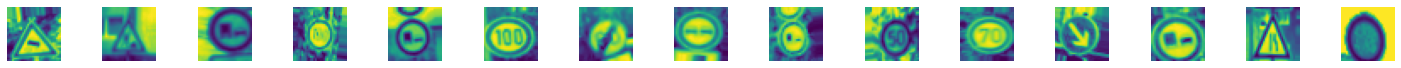

In [32]:
# TO SHOW AGMENTED IMAGE SAMPLES
fig,axs=plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0],imageDimesions[1]))
    axs[i].axis('off')
plt.show()
 
 

In [33]:
y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)

In [51]:

# ############################### CONVOLUTION NEURAL NETWORK MODEL
# def myModel():
#     no_Of_Filters=60
#     size_of_Filter=(5,5) # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
#                          # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
#     size_of_Filter2=(3,3)
#     size_of_pool=(2,2)  # SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
#     no_Of_Nodes = 500   # NO. OF NODES IN HIDDEN LAYERS
#     model= Sequential()
#     model.add((Conv2D(no_Of_Filters,size_of_Filter,input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
#     model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
#     model.add(MaxPooling2D(pool_size=size_of_pool)) # DOES NOT EFFECT THE DEPTH/NO OF FILTERS
 
#     model.add((Conv2D(no_Of_Filters//2, size_of_Filter2,activation='relu')))
#     model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
#     model.add(MaxPooling2D(pool_size=size_of_pool))
#     model.add(Dropout(0.5))
 
#     model.add(Flatten())
#     model.add(Dense(no_Of_Nodes,activation='relu'))
#     model.add(Dropout(0.5)) # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
#     model.add(Dense(noOfClasses,activation='softmax')) # OUTPUT LAYER
#     # COMPILE MODEL
#     model.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
#     return model
 
no_Of_Filters=60
size_of_Filter=(5,5) # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
                      # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
size_of_Filter2=(3,3)
size_of_pool=(2,2)  # SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
no_Of_Nodes = 500   # NO. OF NODES IN HIDDEN LAYERS

model= Sequential()
model.add((Conv2D(no_Of_Filters,size_of_Filter,input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
model.add(MaxPooling2D(pool_size=size_of_pool)) # DOES NOT EFFECT THE DEPTH/NO OF FILTERS

model.add((Conv2D(no_Of_Filters//2, size_of_Filter2,activation='relu')))
model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
model.add(MaxPooling2D(pool_size=size_of_pool))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(no_Of_Nodes,activation='relu'))
model.add(Dropout(0.5)) # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
model.add(Dense(noOfClasses,activation='softmax')) # OUTPUT LAYER

# COMPILE MODEL
model.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])



In [54]:
################# Parameters #####################
 
path = "imagedataset/TrafficSignClassifier/data/myData/images/" # folder with all the class folders
labelFile = 'imagedataset/TrafficSignClassifier/labels.csv' # file with all names of classes
batch_size_val = 50  # how many to process together
steps_per_epoch_val = len(X_train) // batch_size_val
epochs_val = 10
imageDimesions = (32,32,3)
testRatio = 0.2    # if 1000 images split will 200 for testing
validationRatio = 0.2 # if 1000 images 20% of remaining 800 will be 160 for validation
###################################################

In [55]:
 ############################### TRAIN
# model = myModel()

model.fit(X_train, y_train, batch_size = batch_size_val,
                  steps_per_epoch = steps_per_epoch_val,
                  epochs = epochs_val,
                  shuffle = 1, 
                  validation_data=(X_validation,y_validation),
                  callbacks=[early_stopping],
                  verbose = 1)
                            

Epoch 1/10
445/445 [==============================] - 23s 49ms/step - loss: 1.5822 - accuracy: 0.5546 - val_loss: 0.3329 - val_accuracy: 0.9124
Epoch 2/10
445/445 [==============================] - 21s 47ms/step - loss: 0.4641 - accuracy: 0.8531 - val_loss: 0.1516 - val_accuracy: 0.9599
Epoch 3/10
445/445 [==============================] - 21s 48ms/step - loss: 0.3092 - accuracy: 0.9025 - val_loss: 0.1065 - val_accuracy: 0.9738
Epoch 4/10
445/445 [==============================] - 22s 49ms/step - loss: 0.2381 - accuracy: 0.9247 - val_loss: 0.0818 - val_accuracy: 0.9784
Epoch 5/10
445/445 [==============================] - 22s 49ms/step - loss: 0.1992 - accuracy: 0.9355 - val_loss: 0.0669 - val_accuracy: 0.9829
Epoch 6/10
445/445 [==============================] - 22s 49ms/step - loss: 0.1730 - accuracy: 0.9450 - val_loss: 0.0626 - val_accuracy: 0.9820
Epoch 7/10
445/445 [==============================] - 22s 49ms/step - loss: 0.1532 - accuracy: 0.9511 - val_loss: 0.0626 - val_accuracy:

In [56]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_11 (ModuleWra (None, 28, 28, 60)        1560      
_________________________________________________________________
module_wrapper_12 (ModuleWra (None, 24, 24, 60)        90060     
_________________________________________________________________
module_wrapper_13 (ModuleWra (None, 12, 12, 60)        0         
_________________________________________________________________
module_wrapper_14 (ModuleWra (None, 10, 10, 30)        16230     
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 8, 8, 30)          8130      
_________________________________________________________________
module_wrapper_16 (ModuleWra (None, 4, 4, 30)          0         
_________________________________________________________________
module_wrapper_17 (ModuleWra (None, 4, 4, 30)         

In [64]:
def get_config(self):
    config = super().get_config().copy()
    config.update({
        'return_sequences': self.return_sequences 
    })
    return config

In [67]:
get_config(self)

NameError: ignored

In [68]:
from keras.models import load_model

In [57]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [65]:
print(tf.version.VERSION)

2.5.0


In [68]:
# STORE THE MODEL AS A PICKLE OBJECT
# pickle_out= open("trafficsignclassifier.pickle","wb")  # wb = WRITE BYTE
# pickle.dump(model, pickle_out)
# pickle_out.close()
# cv2.waitKey(0)
model.save('drive/MyDrive/Capstone3/TrafficSigns/trafficSignModelweights.h5')

NotImplementedError: ignored

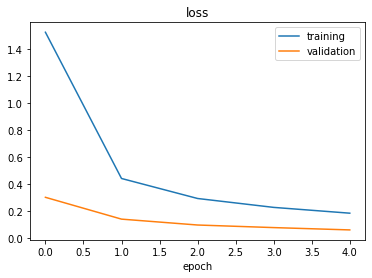

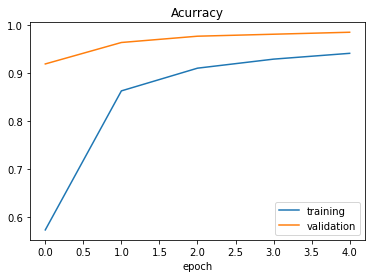

Test Score: 0.059812743216753006
Test Accuracy: 0.9862068891525269


In [48]:
############################### PLOT
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])
 

# Test Code

In [53]:
import numpy as np
import cv2
import pickle

In [54]:
#############################################
 
frameWidth= 640         # CAMERA RESOLUTION
frameHeight = 480
brightness = 180
threshold = 0.75         # PROBABLITY THRESHOLD
font = cv2.FONT_HERSHEY_SIMPLEX
##############################################
 

In [71]:
# SETUP THE VIDEO CAMERA
cap = cv2.VideoCapture(0)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10, brightness)


False

In [24]:

# IMPORT THE TRANNIED MODEL
# pickle_in = open('drive/MyDrive/Capstone3/TrafficSigns/trafficSignModel.h5',"rb")  ## rb = READ BYTE
model = tf.keras.models.load_model('drive/MyDrive/Capstone3/TrafficSigns/trafficSignModel.h5', custom_objects=None, compile=True)

ValueError: ignored

In [ ]:
def grayscale(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img

def equalize(img):
  img =cv2.equalizeHist(img)
  return img

def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img


In [72]:

def getCalssName(classNo):
  if   classNo == 0: 
    return 'Speed Limit 20 km/h'
  elif classNo == 1: 
    return 'Speed Limit 30 km/h'
  elif classNo == 2: 
    return 'Speed Limit 50 km/h'
  elif classNo == 3: 
    return 'Speed Limit 60 km/h'
  elif classNo == 4: 
    return 'Speed Limit 70 km/h'
  elif classNo == 5: 
    return 'Speed Limit 80 km/h'
  elif classNo == 6: 
    return 'End of Speed Limit 80 km/h'
  elif classNo == 7: 
    return 'Speed Limit 100 km/h'
  elif classNo == 8: 
    return 'Speed Limit 120 km/h'
  elif classNo == 9: 
    return 'No passing'
  elif classNo == 10: 
    return 'No passing for vehicles over 3.5 metric tons'
  elif classNo == 11: 
    return 'Right-of-way at the next intersection'
  elif classNo == 12: 
    return 'Priority road'
  elif classNo == 13: 
    return 'Yield'
  elif classNo == 14: 
    return 'Stop'
  elif classNo == 15: 
    return 'No vehicles'
  elif classNo == 16: 
    return 'Vehicles over 3.5 metric tons prohibited'
  elif classNo == 17: 
    return 'No entry'
  elif classNo == 18: 
    return 'General caution'
  elif classNo == 19: 
    return 'Dangerous curve to the left'
  elif classNo == 20: 
    return 'Dangerous curve to the right'
  elif classNo == 21: 
    return 'Double curve'
  elif classNo == 22: 
    return 'Bumpy road'
  elif classNo == 23: 
    return 'Slippery road'
  elif classNo == 24: 
    return 'Road narrows on the right'
  elif classNo == 25: 
    return 'Road work'
  elif classNo == 26: 
    return 'Traffic signals'
  elif classNo == 27: 
    return 'Pedestrians'
  elif classNo == 28: 
    return 'Children crossing'
  elif classNo == 29: 
    return 'Bicycles crossing'
  elif classNo == 30: 
    return 'Beware of ice/snow'
  elif classNo == 31: 
    return 'Wild animals crossing'
  elif classNo == 32: 
    return 'End of all speed and passing limits'
  elif classNo == 33: 
    return 'Turn right ahead'
  elif classNo == 34: 
    return 'Turn left ahead'
  elif classNo == 35: 
    return 'Ahead only'
  elif classNo == 36: 
    return 'Go straight or right'
  elif classNo == 37: 
    return 'Go straight or left'
  elif classNo == 38: 
    return 'Keep right'
  elif classNo == 39: 
    return 'Keep left'
  elif classNo == 40: 
    return 'Roundabout mandatory'
  elif classNo == 41: 
    return 'End of no passing'
  elif classNo == 42: 
    return 'End of no passing by vehicles over 3.5 metric tons'
 

In [73]:

while True:
 
  # READ IMAGE
  success, imgOrignal = cap.read()
  
  # PROCESS IMAGE
  img = np.asarray(imgOrignal)
  img = cv2.resize(img, (32, 32))
  img = preprocessing(img)
  cv2.imshow("Processed Image", img)
  img = img.reshape(1, 32, 32, 1)
  cv2.putText(imgOrignal, "CLASS: " , (20, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
  cv2.putText(imgOrignal, "PROBABILITY: ", (20, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
  
  # PREDICT IMAGE
  predictions = model.predict(img)
  classIndex = model.predict_classes(img)
  probabilityValue =np.amax(predictions)

  if probabilityValue > threshold:
    #print(getCalssName(classIndex))
    cv2.putText(imgOrignal,str(classIndex)+" "+str(getCalssName(classIndex)), (120, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(imgOrignal, str(round(probabilityValue*100,2) )+"%", (180, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.imshow("Result", imgOrignal)
    
  if cv2.waitKey(1) and 0xFF == ord('q'):
    break

TypeError: ignored